<a href="https://colab.research.google.com/github/Harshit50/Stress-and-Effect-Detection/blob/main/Project_2_Harshit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/FDA/Project_2/Pkl/
!ls -lrth

Mounted at /content/drive
/content/drive/MyDrive/FDA/Project_2/Pkl
total 4.5G
-rw------- 1 root root 930M Nov 24  2017 S2.pkl
-rw------- 1 root root 984M Nov 24  2017 S3.pkl
-rw------- 1 root root 948M Nov 24  2017 S5.pkl
-rw------- 1 root root 830M Nov 24  2017 S8.pkl
-rw------- 1 root root 828M Nov 24  2017 S10.pkl


## Providing the functions for complexity, Permutation Entropy and ordinal patterns

In [ ]:
def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

### Reading the Data for 5 Subjects

In [ ]:
# getting data for subject 2
import pickle
with open('S2.pkl', 'rb') as f:
    s2 = pickle.load(f, encoding='latin1')

s2['signal']['chest']

{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
          [ 0.92579997, -0.2216    , -0.55379999],
          [ 0.90820003, -0.21960002, -0.53920001],
          ...,
          [ 0.87179995, -0.12379998, -0.30419999],
          [ 0.87300003, -0.12339997, -0.30260003],
          [ 0.87020004, -0.12199998, -0.30220002]]),
   'ECG': array([[ 0.02142334],
          [ 0.02032471],
          [ 0.01652527],
          ...,
          [-0.00544739],
          [ 0.00013733],
          [ 0.0040741 ]]),
   'EMG': array([[-0.00444031],
          [ 0.00434875],
          [ 0.00517273],
          ...,
          [-0.01716614],
          [-0.02897644],
          [-0.02357483]]),
   'EDA': array([[5.25054932],
          [5.26733398],
          [5.24330139],
          ...,
          [0.36048889],
          [0.36582947],
          [0.365448  ]]),
   'Temp': array([[30.120758],
          [30.129517],
          [30.138214],
          ...,
          [31.459229],
          [31.484283

In [ ]:
data = s2['signal']['chest']['ACC']
dfS2 = pd.DataFrame(data = data, columns = ['S2_Acc_x', 'S2_Acc_y', 'S2_Acc_z'])

def add_multiple_columns(dfS2, column_names, s2, s2_column):
    for col in column_names:
        dfS2[f'S2_{col}'] = s2['signal']['chest'][col]
    return dfS2

column_names = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
dfS2 = add_multiple_columns(dfS2, column_names, s2, 'ECG')

dfS2['S2_State'] = s2.get('label')
dfS2['S2_Subject'] = s2.get('subject')
dfS2

,S2_Acc_x,S2_Acc_y,S2_Acc_z,S2_ECG,S2_EMG,S2_EDA,S2_Temp,S2_Resp,S2_State,S2_Subject
0,0.9554,-0.2220,-0.5580,0.021423,-0.004440,5.250549,30.120758,-1.148987,0,S2
1,0.9258,-0.2216,-0.5538,0.020325,0.004349,5.267334,30.129517,-1.124573,0,S2
2,0.9082,-0.2196,-0.5392,0.016525,0.005173,5.243301,30.138214,-1.152039,0,S2
3,0.8974,-0.2102,-0.5122,0.016708,0.007187,5.249405,30.129517,-1.158142,0,S2
4,0.8882,-0.2036,-0.4824,0.011673,-0.015152,5.286407,30.130951,-1.161194,0,S2
...,...,...,...,...,...,...,...,...,...,...
4255295,0.8750,-0.1234,-0.2974,-0.013138,0.020370,0.400162,31.457733,-1.063538,0,S2
4255296,0.8750,-0.1262,-0.2988,-0.010345,0.019592,0.355911,31.476898,-1.106262,0,S2
4255297,0.8718,-0.1238,-0.3042,-0.005447,-0.017166,0.360489,31.459229,-1.103210,0,S2
4255298,0.8730,-0.1234,-0.3026,0.000137,-0.028976,0.365829,31.484283,-1.086426,0,S2


In [ ]:
# getting data for subject 3
import pickle
with open('S3.pkl', 'rb') as f:
    s3 = pickle.load(f, encoding='latin1')

s3['signal']['chest']

{'ACC': array([[ 7.20000029e-01, -1.38199985e-01,  3.19339991e+00],
        [ 5.68799973e-01, -2.28600025e-01,  3.18219995e+00],
        [ 3.99799943e-01, -3.13199997e-01,  2.94499993e+00],
        ...,
        [ 9.01800036e-01,  5.85999489e-02, -7.79998302e-03],
        [ 9.07400012e-01,  7.62000084e-02,  2.59995461e-03],
        [ 9.68199968e-01,  1.83400035e-01,  1.79999948e-01]]),
 'ECG': array([[-0.75663757],
        [-0.70820618],
        [-0.67396545],
        ...,
        [-0.24847412],
        [-0.18598938],
        [-0.14176941]]),
 'EMG': array([[ 0.00595093],
        [-0.0385437 ],
        [-0.04943848],
        ...,
        [-0.11604309],
        [-0.11082458],
        [-0.06486511]]),
 'EDA': array([[7.98835754],
        [7.98225403],
        [7.98339844],
        ...,
        [7.53211975],
        [7.53059387],
        [7.5340271 ]]),
 'Temp': array([[31.499023],
        [31.501953],
        [31.521149],
        ...,
        [33.228973],
        [33.215393],
        [33.

In [ ]:
data2 = s3['signal']['chest']['ACC']
dfS3 = pd.DataFrame(data = data2, columns = ['S3_Acc_x', 'S3_Acc_y', 'S3_Acc_z'])

def add_multiple_columns(dfS3, column_names, s3, s3_column):
    for col in column_names:
        dfS3[f'S3_{col}'] = s3['signal']['chest'][col]
    return dfS3

column_names = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
dfS3 = add_multiple_columns(dfS3, column_names, s3, 'ECG')
dfS3['S3_State'] = s3.get('label')
dfS3['S3_Subject'] = s3.get('subject')
dfS3

,S3_Acc_x,S3_Acc_y,S3_Acc_z,S3_ECG,S3_EMG,S3_EDA,S3_Temp,S3_Resp,S3_State,S3_Subject
0,0.7200,-0.1382,3.1934,-0.756638,0.005951,7.988358,31.499023,2.204895,0,S3
1,0.5688,-0.2286,3.1822,-0.708206,-0.038544,7.982254,31.501953,2.180481,0,S3
2,0.3998,-0.3132,2.9450,-0.673965,-0.049438,7.983398,31.521149,2.166748,0,S3
3,0.2454,-0.3838,2.4716,-0.535721,-0.014465,7.981873,31.510834,2.191162,0,S3
4,0.0938,-0.4466,1.8758,-0.321808,0.027603,7.978821,31.516724,2.183533,0,S3
...,...,...,...,...,...,...,...,...,...,...
4545095,0.9150,0.0514,0.0192,-0.345840,0.034149,7.535934,33.213867,1.371765,0,S3
4545096,0.9086,0.0554,0.0006,-0.304916,-0.039139,7.533646,33.225922,1.356506,0,S3
4545097,0.9018,0.0586,-0.0078,-0.248474,-0.116043,7.532120,33.228973,1.344299,0,S3
4545098,0.9074,0.0762,0.0026,-0.185989,-0.110825,7.530594,33.215393,1.341248,0,S3


In [ ]:
# getting data for subject 5
import pickle
with open('S5.pkl', 'rb') as f:
    s5 = pickle.load(f, encoding='latin1')

s5['signal']['chest']

{'ACC': array([[ 0.86059999,  0.07420003,  0.85699999],
        [ 0.84560001,  0.07799995,  0.85739994],
        [ 0.84099996,  0.08739996,  0.75699997],
        ...,
        [ 0.90960002, -0.05620003, -0.12940001],
        [ 0.9102    , -0.05580002, -0.13260001],
        [ 0.91059995, -0.05680001, -0.13739997]]),
 'ECG': array([[-0.27580261],
        [-0.22975159],
        [-0.19528198],
        ...,
        [ 0.01487732],
        [ 0.0292511 ],
        [ 0.03886414]]),
 'EMG': array([[ 0.01679993],
        [ 0.01496887],
        [ 0.01533508],
        ...,
        [-0.01368713],
        [-0.00100708],
        [ 0.003479  ]]),
 'EDA': array([[ 3.88832092],
        [ 3.91311646],
        [ 3.87306213],
        ...,
        [10.23101807],
        [10.2306366 ],
        [10.2306366 ]]),
 'Temp': array([[34.119934],
        [34.142822],
        [34.135193],
        ...,
        [34.949463],
        [34.97107 ],
        [34.940247]], dtype=float32),
 'Resp': array([[0.04425049],
        [0

In [ ]:
data3 = s5['signal']['chest']['ACC']
dfS5 = pd.DataFrame(data = data3, columns = ['S5_Acc_x', 'S5_Acc_y', 'S5_Acc_z'])

def add_multiple_columns(dfS5, column_names, s5, s5_column):
    for col in column_names:
        dfS5[f'S5_{col}'] = s5['signal']['chest'][col]
    return dfS5

column_names = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
dfS5 = add_multiple_columns(dfS5, column_names, s5, 'ECG')
dfS5['S5_State'] = s5.get('label')
dfS5['S5_Subject'] = s5.get('subject')
dfS5

,S5_Acc_x,S5_Acc_y,S5_Acc_z,S5_ECG,S5_EMG,S5_EDA,S5_Temp,S5_Resp,S5_State,S5_Subject
0,0.8606,0.0742,0.8570,-0.275803,0.016800,3.888321,34.119934,0.044250,0,S5
1,0.8456,0.0780,0.8574,-0.229752,0.014969,3.913116,34.142822,0.032043,0,S5
2,0.8410,0.0874,0.7570,-0.195282,0.015335,3.873062,34.135193,0.015259,0,S5
3,0.8418,0.0986,0.5782,-0.164474,-0.003708,3.883362,34.136749,-0.062561,0,S5
4,0.8554,0.0984,0.3332,-0.134811,0.017624,3.886795,34.118439,0.016785,0,S5
...,...,...,...,...,...,...,...,...,...,...
4380595,0.9086,-0.0578,-0.1242,-0.008240,0.009293,10.231400,34.971069,7.070923,0,S5
4380596,0.9086,-0.0572,-0.1286,-0.000778,-0.004074,10.231018,34.900116,7.044983,0,S5
4380597,0.9096,-0.0562,-0.1294,0.014877,-0.013687,10.231018,34.949463,7.057190,0,S5
4380598,0.9102,-0.0558,-0.1326,0.029251,-0.001007,10.230637,34.971069,7.090759,0,S5


In [ ]:
# getting data for subject 8
import pickle
with open('S8.pkl', 'rb') as f:
    s8 = pickle.load(f, encoding='latin1')

s8['signal']['chest']

{'ACC': array([[ 8.74600053e-01, -2.31999755e-02,  2.76200056e-01],
        [ 8.80200028e-01, -1.13999844e-02,  2.63800025e-01],
        [ 8.86999965e-01,  2.00033188e-04,  2.38199949e-01],
        ...,
        [ 9.13800001e-01, -4.99999523e-03, -6.01999760e-02],
        [ 9.13800001e-01, -5.80000877e-03, -5.86000085e-02],
        [ 9.14600015e-01, -7.20000267e-03, -6.26000166e-02]]),
 'ECG': array([[ 0.16950989],
        [ 0.16639709],
        [ 0.16337585],
        ...,
        [-0.02183533],
        [-0.01629639],
        [-0.00823975]]),
 'EMG': array([[-0.00535583],
        [ 0.00993347],
        [ 0.01478577],
        ...,
        [-0.00119019],
        [-0.0100708 ],
        [-0.00979614]]),
 'EDA': array([[4.36859131],
        [4.37202454],
        [4.38194275],
        ...,
        [3.51028442],
        [3.50608826],
        [3.50456238]]),
 'Temp': array([[34.264893],
        [34.28018 ],
        [34.263397],
        ...,
        [35.432373],
        [35.547394],
        [35.

In [ ]:
data4 = s8['signal']['chest']['ACC']
dfS8 = pd.DataFrame(data = data4, columns = ['S8_Acc_x', 'S8_Acc_y', 'S8_Acc_z'])

def add_multiple_columns(dfS8, column_names, s8, s8_column):
    for col in column_names:
        dfS8[f'S8_{col}'] = s8['signal']['chest'][col]
    return dfS8

column_names = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
dfS8 = add_multiple_columns(dfS8, column_names, s8, 'ECG')
dfS8['S8_State'] = s8.get('label')
dfS8['S8_Subject'] = s8.get('subject')
dfS8

,S8_Acc_x,S8_Acc_y,S8_Acc_z,S8_ECG,S8_EMG,S8_EDA,S8_Temp,S8_Resp,S8_State,S8_Subject
0,0.8746,-0.0232,0.2762,0.169510,-0.005356,4.368591,34.264893,-1.718140,0,S8
1,0.8802,-0.0114,0.2638,0.166397,0.009933,4.372025,34.280182,-1.716614,0,S8
2,0.8870,0.0002,0.2382,0.163376,0.014786,4.381943,34.263397,-1.705933,0,S8
3,0.8954,0.0176,0.2030,0.153259,0.015884,4.365921,34.271027,-1.710510,0,S8
4,0.9002,0.0326,0.1486,0.147629,0.028381,4.366684,34.261841,-1.713562,0,S8
...,...,...,...,...,...,...,...,...,...,...
3826195,0.9150,-0.0078,-0.0558,-0.022842,0.006363,3.517151,35.528717,0.733948,0,S8
3826196,0.9160,-0.0082,-0.0586,-0.024216,0.002335,3.516388,35.519409,0.730896,0,S8
3826197,0.9138,-0.0050,-0.0602,-0.021835,-0.001190,3.510284,35.432373,0.727844,0,S8
3826198,0.9138,-0.0058,-0.0586,-0.016296,-0.010071,3.506088,35.547394,0.703430,0,S8


In [ ]:
# getting data for subject 10
import pickle
with open('S10.pkl', 'rb') as f:
    s10 = pickle.load(f, encoding='latin1')

s10['signal']['chest']

{'ACC': array([[ 1.12779999,  0.15199995,  0.34159994],
        [ 1.09319997,  0.18879998,  0.29219997],
        [ 1.03539991,  0.20940006,  0.18579996],
        ...,
        [ 0.89419997,  0.03380001, -0.21460003],
        [ 0.89499998,  0.03419995, -0.21820003],
        [ 0.89639997,  0.03260005, -0.22140002]]),
 'ECG': array([[-1.33369446],
        [-1.32774353],
        [-1.32206726],
        ...,
        [ 0.53050232],
        [ 0.53375244],
        [ 0.54057312]]),
 'EMG': array([[-0.01368713],
        [-0.02192688],
        [-0.00901794],
        ...,
        [ 0.00654602],
        [-0.00141907],
        [-0.00814819]]),
 'EDA': array([[0.71601868],
        [0.7144928 ],
        [0.71563721],
        ...,
        [1.70440674],
        [1.74827576],
        [1.72462463]]),
 'Temp': array([[33.69586 ],
        [33.741333],
        [33.71707 ],
        ...,
        [35.020447],
        [34.932495],
        [34.944824]], dtype=float32),
 'Resp': array([[ 0.21362305],
        [ 0.192

In [ ]:
data5 = s10['signal']['chest']['ACC']
dfS10 = pd.DataFrame(data = data5, columns = ['S10_Acc_x', 'S10_Acc_y', 'S10_Acc_z'])

def add_multiple_columns(dfS10, column_names, s10, s10_column):
    for col in column_names:
        dfS10[f'S10_{col}'] = s10['signal']['chest'][col]
    return dfS10

column_names = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
dfS10 = add_multiple_columns(dfS10, column_names, s10, 'ECG')
dfS10['S10_State'] = s10.get('label')
dfS10['S10_Subject'] = s10.get('subject')
dfS10

,S10_Acc_x,S10_Acc_y,S10_Acc_z,S10_ECG,S10_EMG,S10_EDA,S10_Temp,S10_Resp,S10_State,S10_Subject
0,1.1278,0.1520,0.3416,-1.333694,-0.013687,0.716019,33.695862,0.213623,0,S10
1,1.0932,0.1888,0.2922,-1.327744,-0.021927,0.714493,33.741333,0.192261,0,S10
2,1.0354,0.2094,0.1858,-1.322067,-0.009018,0.715637,33.717072,0.205994,0,S10
3,0.9666,0.2118,0.0412,-1.316345,-0.002380,0.714874,33.741333,0.193787,0,S10
4,0.8916,0.2040,-0.1228,-1.310257,0.001053,0.715256,33.747406,0.172424,0,S10
...,...,...,...,...,...,...,...,...,...,...
3847195,0.8946,0.0354,-0.2150,0.522949,0.017029,1.720810,35.015808,-2.032471,0,S10
3847196,0.8926,0.0334,-0.2178,0.526932,0.002060,1.707077,35.018921,-2.030945,0,S10
3847197,0.8942,0.0338,-0.2146,0.530502,0.006546,1.704407,35.020447,-2.183533,0,S10
3847198,0.8950,0.0342,-0.2182,0.533752,-0.001419,1.748276,34.932495,-2.003479,0,S10


In [ ]:
samples = 10
sample_length = 4096
labels = {1: 'Baseline',
          2: 'Stress',
          3: 'Amusement',
          4: 'Meditation'}

modalities = ['ACC', 'ECG', 'EDA', 'EMG', 'RESP', 'TEMP']
selected_subjects = ['S2', 'S3', 'S5', 'S8', 'S10']


### Dividing the data into various samples for various subjects

In [ ]:
# sample for subject S2
def extract_samples(df, state_column='S2_State', num_samples=10, sample_length=4096):

  samples_by_state = {}
  for state in df[state_column].unique():
    state_data = df[df[state_column] == state]
    max_segments = len(state_data) // sample_length

    if max_segments < num_samples:
      print(f"Warning: Insufficient data for state {state}. Only {max_segments} segments can be extracted.")
      continue

    start_indices = np.random.choice(
        range(0, len(state_data) - sample_length + 1, sample_length),
        num_samples,
        replace=False
    )

    # Extract samples
    samples_by_state[state] = [
        state_data.iloc[start : start + sample_length]
        for start in start_indices
    ]

  return samples_by_state

random_samples = extract_samples(dfS2, state_column='S2_State', num_samples=10, sample_length=4096)

interval = random_samples[1]
interval

[        S2_Acc_x  S2_Acc_y  S2_Acc_z    S2_ECG    S2_EMG    S2_EDA    S2_Temp  \
 243255    0.6168   -0.1102   -0.7206  0.024490  0.005081  4.769897  29.165558   
 243256    0.6146   -0.1098   -0.7216  0.022568  0.003983  4.789734  29.210144   
 243257    0.6162   -0.1086   -0.7218  0.024948 -0.000687  4.771042  29.142578   
 243258    0.6150   -0.1096   -0.7238  0.026505 -0.002060  4.777145  29.154053   
 243259    0.6170   -0.1090   -0.7234  0.029617  0.001694  4.766464  29.208710   
 ...          ...       ...       ...       ...       ...       ...        ...   
 247346    0.6324   -0.1142   -0.7154  0.002518 -0.011765  4.689026  29.188568   
 247347    0.6318   -0.1142   -0.7148  0.001511 -0.008286  4.693985  29.100861   
 247348    0.6302   -0.1140   -0.7142  0.002518 -0.000366  4.711151  29.115234   
 247349    0.6302   -0.1166   -0.7126  0.001694 -0.008194  4.690933  29.122437   
 247350    0.6290   -0.1156   -0.7112  0.002792 -0.004990  4.658508  29.095123   
 
          S2_R

In [ ]:
# samples for subject S3
def extract_samples(df, state_column='S3_State', num_samples=10, sample_length=4096):

  samples_by_state = {}
  for state in df[state_column].unique():
    state_data = df[df[state_column] == state]
    max_segments = len(state_data) // sample_length

    if max_segments < num_samples:
      print(f"Warning: Insufficient data for state {state}. Only {max_segments} segments can be extracted.")
      continue

    start_indices = np.random.choice(
        range(0, len(state_data) - sample_length + 1, sample_length),
        num_samples,
        replace=False
    )

    # Extract samples
    samples_by_state[state] = [
        state_data.iloc[start : start + sample_length]
        for start in start_indices
    ]

  return samples_by_state

random_samples = extract_samples(dfS3, state_column='S3_State', num_samples=10, sample_length=4096)

interval = random_samples[4]
interval

[         S3_Acc_x  S3_Acc_y  S3_Acc_z    S3_ECG    S3_EMG    S3_EDA  \
 3286326    0.8842   -0.0136   -0.1798 -0.248749  0.016434  7.147598   
 3286327    0.8828   -0.0154   -0.1866 -0.249802  0.007507  7.152176   
 3286328    0.8818   -0.0150   -0.1870 -0.251907  0.003525  7.149887   
 3286329    0.8830   -0.0152   -0.1934 -0.251495 -0.003525  7.150269   
 3286330    0.8814   -0.0152   -0.1924 -0.250488 -0.000778  7.149887   
 ...           ...       ...       ...       ...       ...       ...   
 4073716    0.8442   -0.0146   -0.3866  0.025085 -0.009750  7.516098   
 4073717    0.8414   -0.0118   -0.3886  0.023483  0.000687  7.503891   
 4073718    0.8408   -0.0114   -0.3878  0.022614 -0.002335  7.504272   
 4073719    0.8398   -0.0136   -0.3876  0.022888 -0.001877  7.508087   
 4073720    0.8402   -0.0142   -0.3880  0.023300 -0.000687  7.505798   
 
            S3_Temp   S3_Resp  S3_State S3_Subject  
 3286326  32.956757  5.426025         4         S3  
 3286327  32.989807  5.43975

In [ ]:
# samples for subject S5
def extract_samples(df, state_column='S5_State', num_samples=10, sample_length=4096):

  samples_by_state = {}
  for state in df[state_column].unique():
    state_data = df[df[state_column] == state]
    max_segments = len(state_data) // sample_length

    if max_segments < num_samples:
      print(f"Warning: Insufficient data for state {state}. Only {max_segments} segments can be extracted.")
      continue

    start_indices = np.random.choice(
        range(0, len(state_data) - sample_length + 1, sample_length),
        num_samples,
        replace=False
    )

    # Extract samples
    samples_by_state[state] = [
        state_data.iloc[start : start + sample_length]
        for start in start_indices
    ]

  return samples_by_state

random_samples = extract_samples(dfS5, state_column='S5_State', num_samples=10, sample_length=4096)

interval = random_samples[2]
interval

[         S5_Acc_x  S5_Acc_y  S5_Acc_z    S5_ECG    S5_EMG    S5_EDA  \
 2619964    0.9162   -0.0334   -0.0774 -0.052505 -0.005676  9.783173   
 2619965    0.9150   -0.0354   -0.0776 -0.055481 -0.012222  9.783173   
 2619966    0.9144   -0.0358   -0.0722 -0.057632  0.001694  9.781265   
 2619967    0.9134   -0.0360   -0.0700 -0.061203  0.003159  9.781265   
 2619968    0.9174   -0.0330   -0.0710 -0.066055  0.010254  9.781647   
 ...           ...       ...       ...       ...       ...       ...   
 2624055    0.9214   -0.0214   -0.0598  0.225540 -0.020554  9.547424   
 2624056    0.9214   -0.0206   -0.0582  0.362961 -0.028336  9.548950   
 2624057    0.9214   -0.0194   -0.0578  0.544373 -0.020691  9.550095   
 2624058    0.9210   -0.0198   -0.0578  0.755539  0.002792  9.556580   
 2624059    0.9202   -0.0206   -0.0582  0.979477  0.019821  9.550476   
 
            S5_Temp   S5_Resp  S5_State S5_Subject  
 2619964  35.127045  1.947021         2         S5  
 2619965  35.114716  1.93023

In [ ]:
# samples for subject S8
def extract_samples(df, state_column='S8_State', num_samples=10, sample_length=4096):

  samples_by_state = {}
  for state in df[state_column].unique():
    state_data = df[df[state_column] == state]
    max_segments = len(state_data) // sample_length

    if max_segments < num_samples:
      print(f"Warning: Insufficient data for state {state}. Only {max_segments} segments can be extracted.")
      continue

    start_indices = np.random.choice(
        range(0, len(state_data) - sample_length + 1, sample_length),
        num_samples,
        replace=False
    )

    # Extract samples
    samples_by_state[state] = [
        state_data.iloc[start : start + sample_length]
        for start in start_indices
    ]

  return samples_by_state

random_samples = extract_samples(dfS8, state_column='S8_State', num_samples=10, sample_length=4096)

interval = random_samples[4]
interval

[         S8_Acc_x  S8_Acc_y  S8_Acc_z    S8_ECG    S8_EMG    S8_EDA  \
 3569460    0.6442    0.0270   -0.6998  0.023621 -0.005630  3.547287   
 3569461    0.6446    0.0290   -0.6984  0.019272 -0.001236  3.531265   
 3569462    0.6462    0.0282   -0.6980  0.014832  0.007782  3.529358   
 3569463    0.6450    0.0296   -0.6982  0.007462 -0.000916  3.532791   
 3569464    0.6464    0.0302   -0.6958  0.000046  0.004944  3.541183   
 ...           ...       ...       ...       ...       ...       ...   
 3573551    0.6462    0.0250   -0.7006 -0.159348  0.002518  3.542328   
 3573552    0.6458    0.0242   -0.6990 -0.157242  0.002655  3.529358   
 3573553    0.6488    0.0232   -0.6970 -0.157516  0.000412  3.528976   
 3573554    0.6510    0.0242   -0.6994 -0.158340 -0.014877  3.528976   
 3573555    0.6538    0.0218   -0.6976 -0.156921 -0.001419  3.528976   
 
            S8_Temp   S8_Resp  S8_State S8_Subject  
 3569460  35.500732  0.874329         4         S8  
 3569461  35.464996  0.87738

In [ ]:
# samples for subject S10
def extract_samples(df, state_column='S10_State', num_samples=10, sample_length=4096):

  samples_by_state = {}
  for state in df[state_column].unique():
    state_data = df[df[state_column] == state]
    max_segments = len(state_data) // sample_length

    if max_segments < num_samples:
      print(f"Warning: Insufficient data for state {state}. Only {max_segments} segments can be extracted.")
      continue

    start_indices = np.random.choice(
        range(0, len(state_data) - sample_length + 1, sample_length),
        num_samples,
        replace=False
    )

    # Extract samples
    samples_by_state[state] = [
        state_data.iloc[start : start + sample_length]
        for start in start_indices
    ]

  return samples_by_state

random_samples = extract_samples(dfS10, state_column='S10_State', num_samples=10, sample_length=4096)

interval = random_samples[3]
interval

[         S10_Acc_x  S10_Acc_y  S10_Acc_z   S10_ECG   S10_EMG   S10_EDA  \
 1137580     0.7098     0.0232    -0.6146 -0.130417 -0.001602  0.899124   
 1137581     0.7094     0.0242    -0.6152 -0.187546 -0.002472  0.896835   
 1137582     0.7082     0.0232    -0.6176 -0.232590 -0.005356  0.891113   
 1137583     0.7074     0.0254    -0.6150 -0.268936 -0.004349  0.889969   
 1137584     0.7074     0.0266    -0.6180 -0.293701 -0.008606  0.916290   
 ...            ...        ...        ...       ...       ...       ...   
 1141671     0.7082     0.0224    -0.6148  0.034012 -0.000870  0.891495   
 1141672     0.7090     0.0222    -0.6182  0.035110 -0.003983  0.904465   
 1141673     0.7070     0.0222    -0.6198  0.036804 -0.003845  0.902176   
 1141674     0.7078     0.0234    -0.6222  0.035202 -0.010666  0.893784   
 1141675     0.7086     0.0226    -0.6194  0.036850 -0.009476  0.889206   
 
           S10_Temp  S10_Resp  S10_State S10_Subject  
 1137580  34.518951  2.787781          3   

### Defining a function to calculate Permutation Entropy and Complexity for various states and samples

In [ ]:
import pandas as pd

def calculate_cecp(data_segment, embedding_dimension=4, embedding_delay=1):
    # calculate ordinal pattern
    ordinal_patterns_values = ordinal_patterns(data_segment, embedding_dimension, embedding_delay)
    # calculate permutation entropy
    permutation_entropy = p_entropy(ordinal_patterns_values)
    # calculate complexity
    complexity_value = complexity(ordinal_patterns_values)
    return permutation_entropy, complexity_value

all_results = []

subject_ids = ['S2','S3','S5','S8','S10']
states = [1, 2, 3, 4]
number_of_samples = 10
# adding all columns
signal_columns = ['Acc_x', 'Acc_y', 'Acc_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']


for subject_id in subject_ids:
    subject_data = globals()[f'df{subject_id}']
    for state in states:
        for sample_number in range(number_of_samples):
            for signal_column in signal_columns:

                column_name = f'{subject_id}_{signal_column}'
                data_segment = subject_data[(subject_data[f'{subject_id}_State'] == state) & (subject_data[f'{subject_id}_Subject'] == subject_id)][column_name][sample_number * 4096 : (sample_number + 1) * 4096]

                if len(data_segment) < 4096:
                    print(f"Warning: Data segment too short for subject {subject_id}, state {state}, sample {sample_number}, signal {signal_column}. Skipping...")
                    continue

                permutation_entropy, complexity_value = calculate_cecp(data_segment)
                all_results.append([subject_id, state, sample_number + 1, signal_column, permutation_entropy, complexity_value])

results_df = pd.DataFrame(all_results, columns=['Subject', 'State', 'Sample', 'Signal', 'Permutation Entropy', 'Complexity'])

# Pivot df to get columns
results_df_1 = pd.pivot_table(
    results_df,
    values=['Permutation Entropy', 'Complexity'],
    index=['Subject', 'State', 'Sample'],
    columns=['Signal']
)


results_df_1.columns = ['_'.join(col) for col in results_df_1.columns]
results_df_1 = results_df_1.reset_index()
results_df_1

<ipython-input-3-228a32f540e2>:37: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-3-228a32f540e2>:28: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


,Subject,State,Sample,Complexity_Acc_x,Complexity_Acc_y,Complexity_Acc_z,Complexity_ECG,Complexity_EDA,Complexity_EMG,Complexity_Resp,Complexity_Temp,Permutation Entropy_Acc_x,Permutation Entropy_Acc_y,Permutation Entropy_Acc_z,Permutation Entropy_ECG,Permutation Entropy_EDA,Permutation Entropy_EMG,Permutation Entropy_Resp,Permutation Entropy_Temp
0,S10,1,1,0.047433,0.047289,0.066603,0.232877,0.088158,0.018436,0.024670,0.017854,0.959805,0.960472,0.940955,0.692005,0.922776,0.985572,0.980222,0.986611
1,S10,1,2,0.040399,0.045433,0.069995,0.243798,0.085713,0.024114,0.097632,0.016476,0.965941,0.962299,0.937889,0.677598,0.923738,0.981243,0.909367,0.987684
2,S10,1,3,0.040392,0.039853,0.066442,0.242574,0.105889,0.023392,0.038940,0.012139,0.965940,0.966420,0.940794,0.658770,0.902245,0.981270,0.967444,0.990966
3,S10,1,4,0.037004,0.040399,0.059000,0.245817,0.152315,0.032098,0.047838,0.017689,0.968987,0.966799,0.948344,0.660847,0.856615,0.974633,0.959878,0.986721
4,S10,1,5,0.042904,0.034487,0.070107,0.244803,0.113891,0.026601,0.052628,0.006301,0.962701,0.971248,0.938193,0.660536,0.897490,0.978621,0.955015,0.995171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,S8,4,6,0.042335,0.036108,0.039704,0.206001,0.123834,0.013387,0.034701,0.018656,0.964245,0.969640,0.966535,0.757451,0.894573,0.989757,0.971612,0.985181
196,S8,4,7,0.056945,0.045025,0.046235,0.218384,0.117008,0.045816,0.033769,0.027558,0.951235,0.962029,0.961259,0.741328,0.897784,0.960471,0.972665,0.977806
197,S8,4,8,0.048666,0.041705,0.051544,0.213170,0.115575,0.026536,0.061525,0.020827,0.959004,0.965611,0.956870,0.746347,0.901293,0.979085,0.941955,0.983544
198,S8,4,9,0.039629,0.042029,0.053129,0.221372,0.121926,0.015362,0.039898,0.018733,0.966885,0.965036,0.955823,0.733286,0.895671,0.988133,0.967371,0.984958


### Displaying different states for different subjects in the form of scatter plots

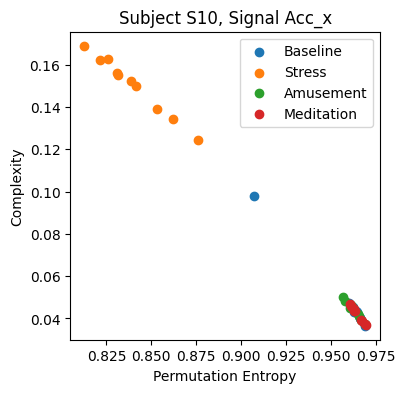

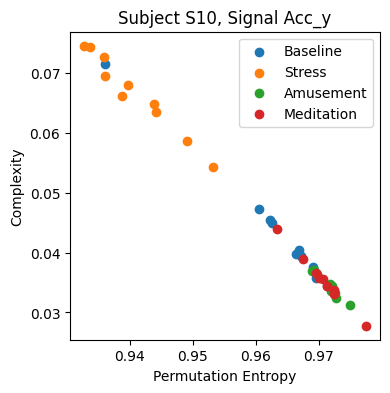

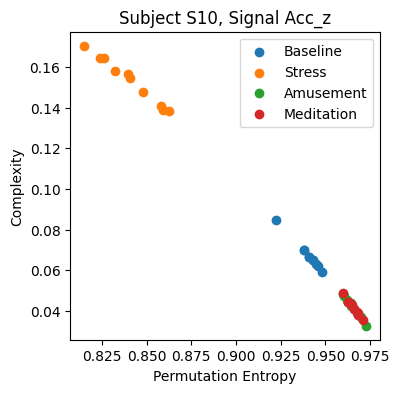

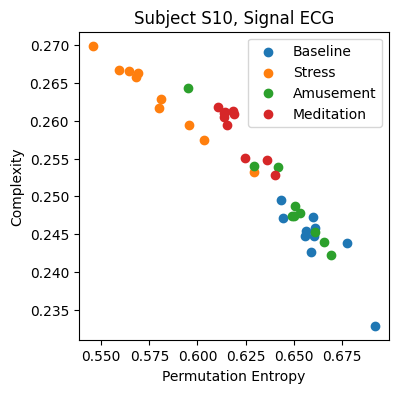

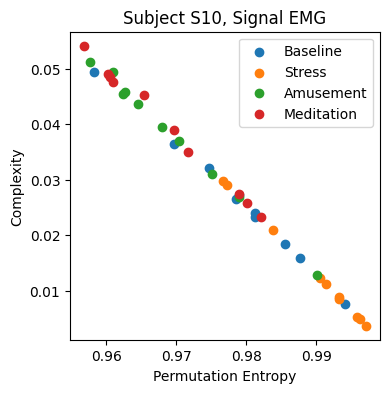

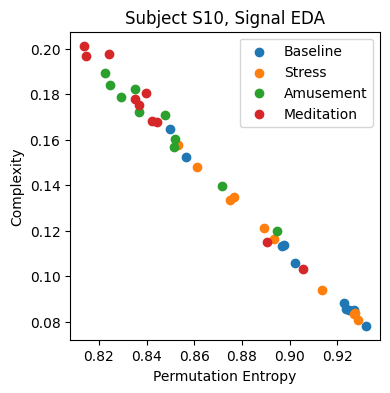

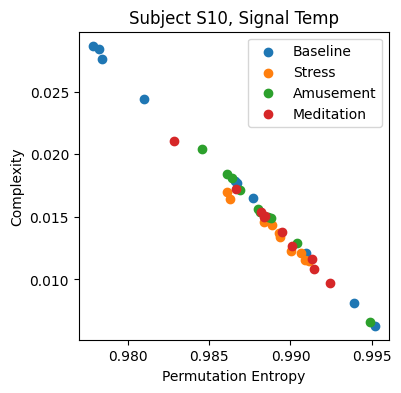

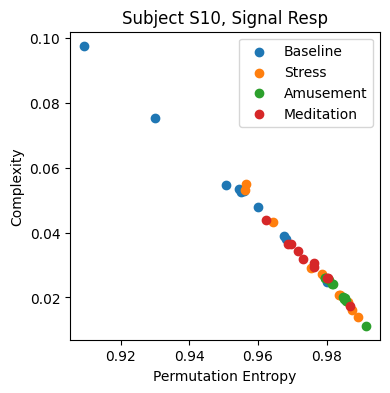

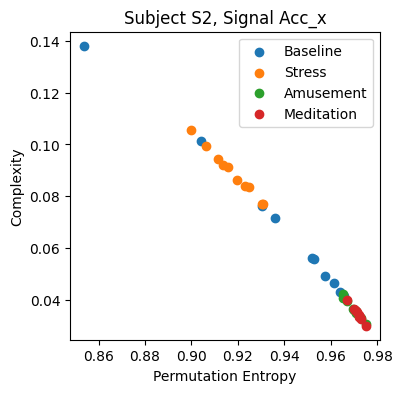

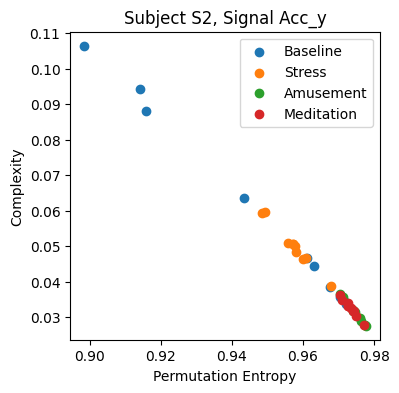

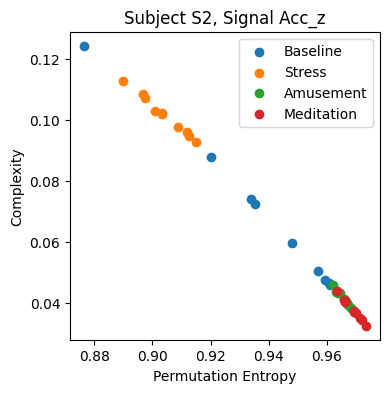

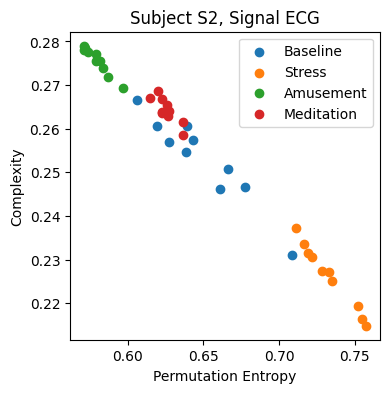

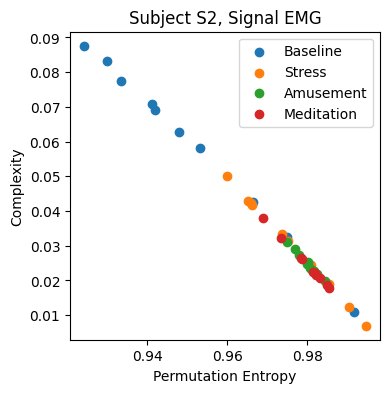

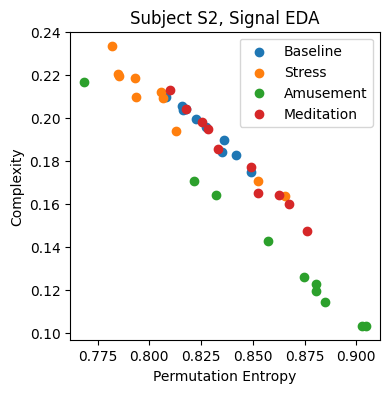

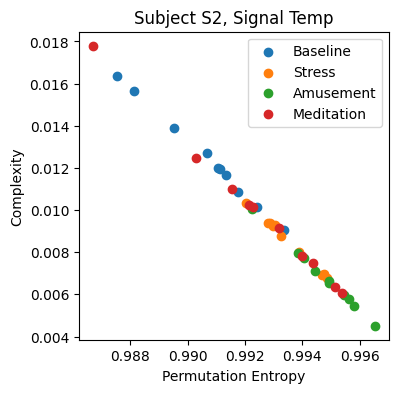

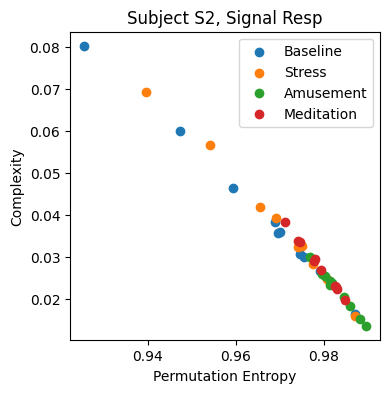

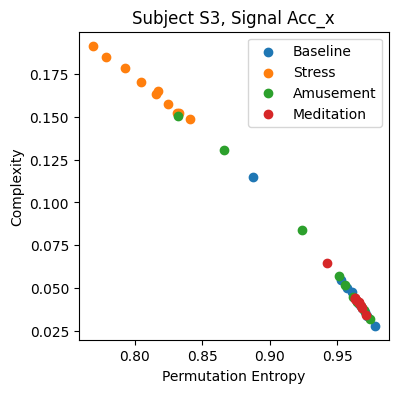

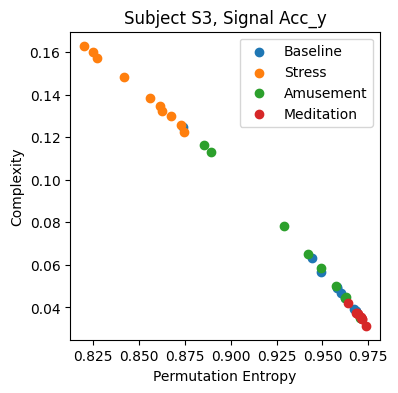

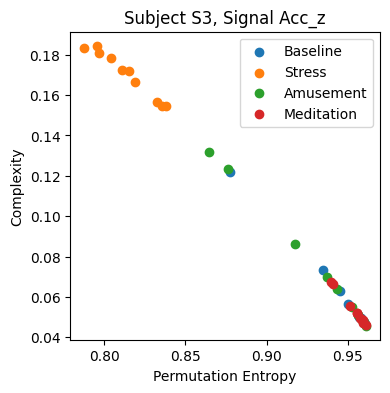

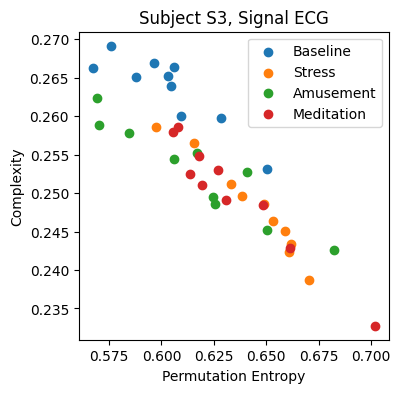

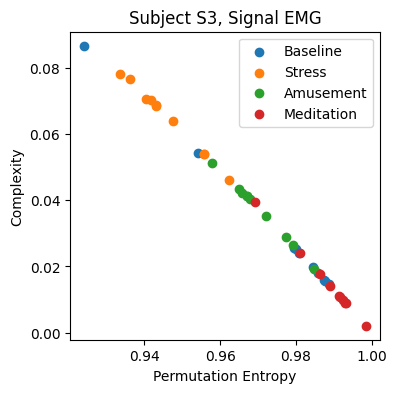

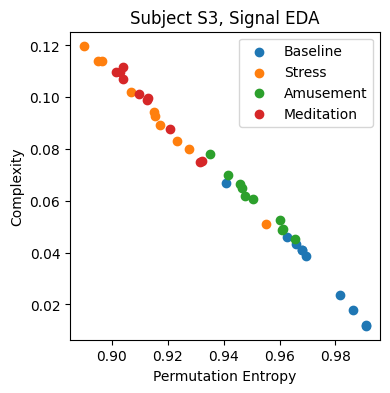

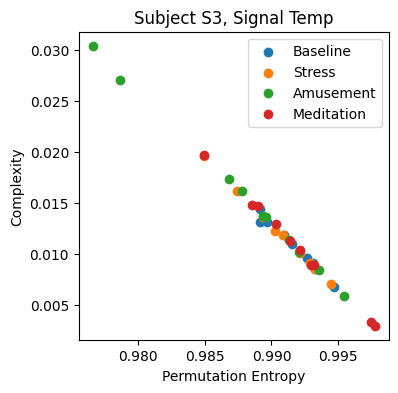

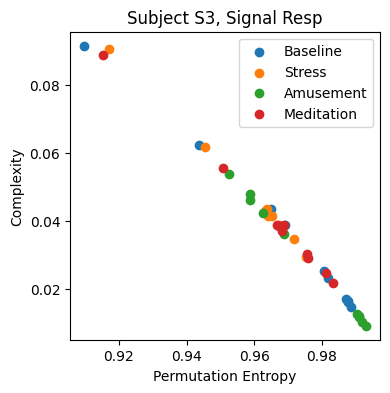

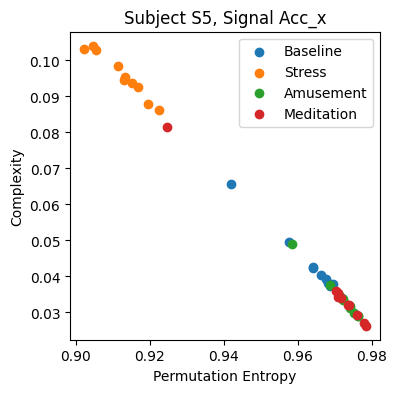

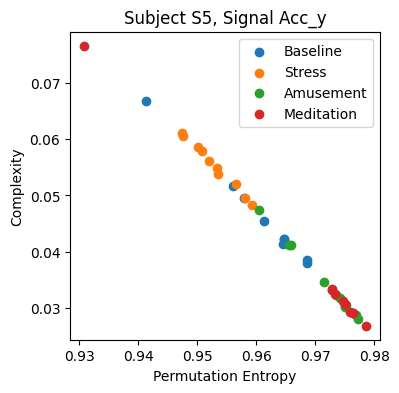

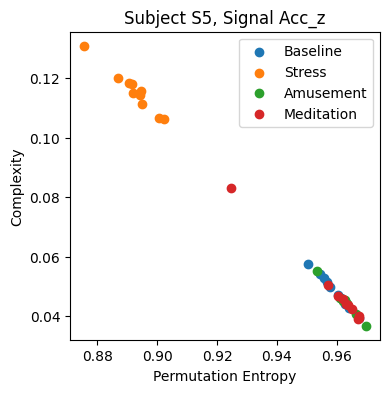

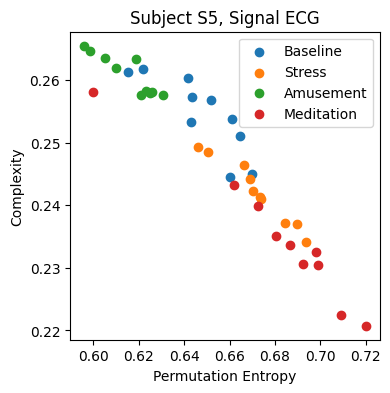

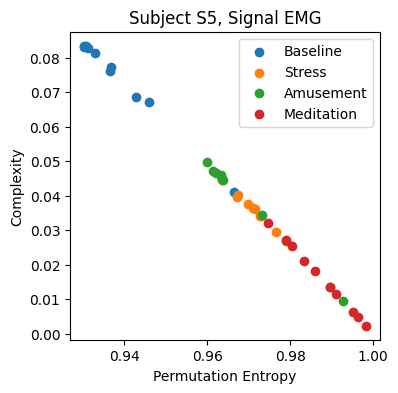

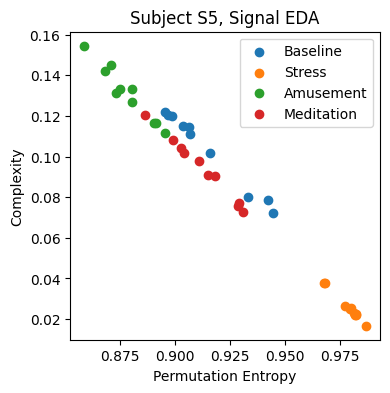

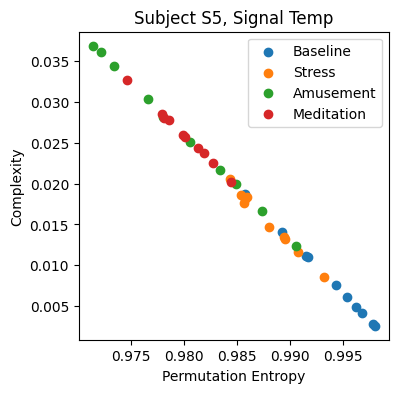

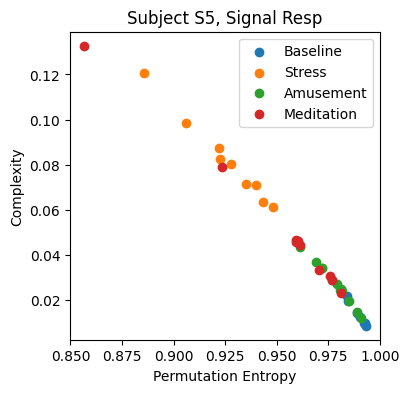

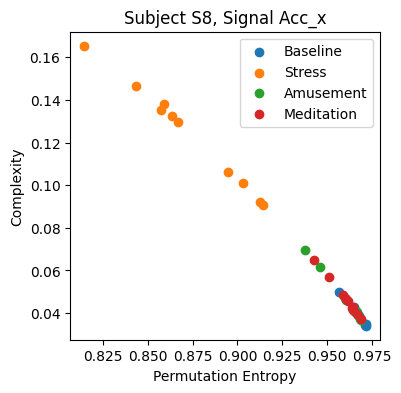

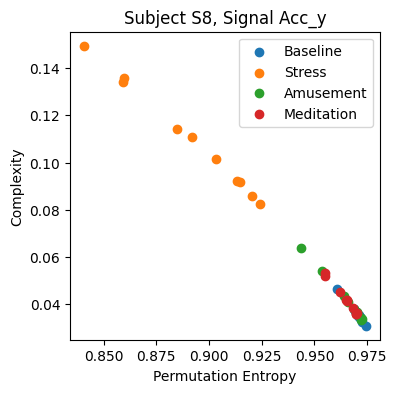

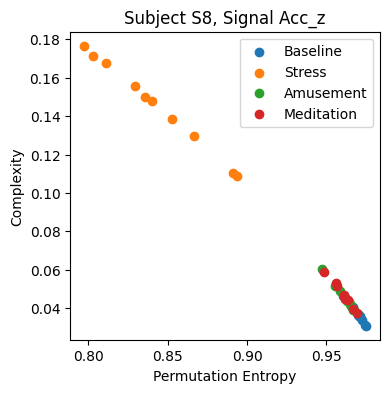

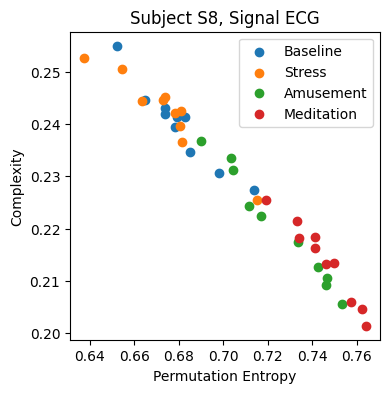

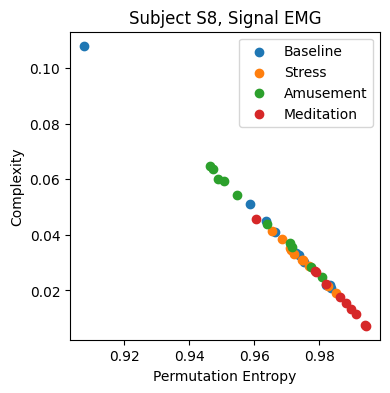

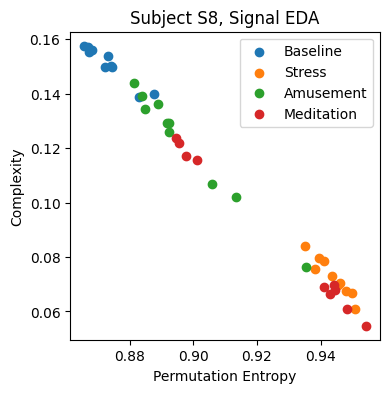

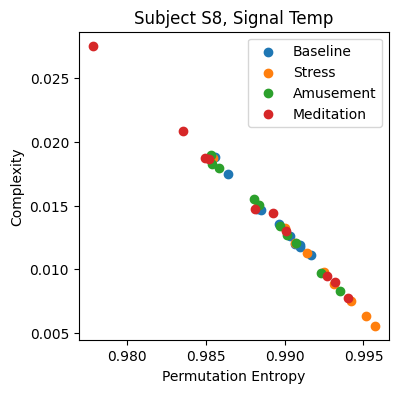

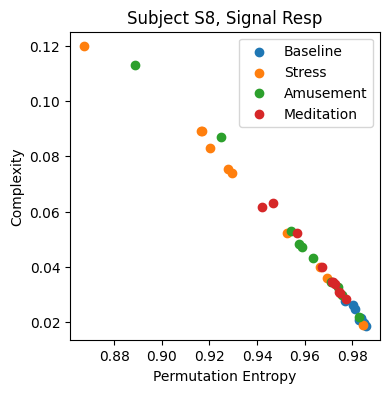

In [ ]:
import matplotlib.pyplot as plt

for subject in results_df_1['Subject'].unique():
    for signal in ['Acc_x', 'Acc_y', 'Acc_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']:
        plt.figure(figsize=(4, 4))

        for state in results_df_1['State'].unique():
            subset = results_df_1[
                (results_df_1['Subject'] == subject) &
                (results_df_1['State'] == state)
            ]

            plt.scatter(
                subset[f'Permutation Entropy_{signal}'],
                subset[f'Complexity_{signal}'],
                label=labels.get(state, f'State {state}') # Using labels here
            )
        plt.title(f'Subject {subject}, Signal {signal}')
        plt.xlabel('Permutation Entropy')
        plt.ylabel('Complexity')
        plt.legend()
        plt.show()
